<div>
  <h1>User Research on Stype preference</h1>
  <h2><b>Situation</b></h2>
  <p>This is a user research project in a fashion e-commerce startup in 2021.<br>Back then, our important operational KPI was an average order value.<br>
 Since the launch of the service, this number had been around 2000 TWD. <br>
  </p>
  <h2><b>Task</b></h2>
  <p>My Mission was to find a product improvement opportunity to enhance this KPI.</p>

  <h2><b>Action</b></h2>
  <p>I ran both quantitative and qualitative analysis for this project.</p>
  <h3>1. Qualitative Analysis</h3>

  <p>In the user interviews with our loyal customers, we realized our recommendation lacked diversity in fashion styles such as sporty, elegant, street and soon. From here, we created hypothesis that recommending more diverse products would contribute user satisfaction.</p>
  <h3>2. Quantitative Analysis <a color = "red">(in this notebook!)</a></h3>
  <p>
  Next, I tried to validate this hypothesis by checking whether the users who interacts with a variety of styles buy more products per order than the users who like a limited number of styles.<br>
  I labeled all the products with the 13 fashion styles our stylist team defined, and calculated the distribution of style preference from product data, order data, and pageview data, like Sport 50%, Elegant 0%, Natural 30%, Street 20%.<br>
  Then I clustered them into 5 groups by the distribution of style preference.</p>

<h2><b>Result</b></h2>
<p>
  It turned out the more various styles a user prefers, the more they spend with more frequency. <b>The group with the most diverse preference spend 56% more than the group with the least diverse preference.</b><br>
  Thus our hypothesis was validated. <br>
  After that, we worked on this opportunity and improved our recommendation on another project, it increased the KPI by <b>15%</b>.</p>
</div>

#Import libraries

In [ ]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


#Fetch the latest data from BIG QUERY

In [ ]:
#define a SQL code here. I fetch product data, order data, and Google Analytics's behavioral data.
sql = '''WITH buy AS(
    SELECT
        ODMCUSID AS MemberId
        ,Count(Distinct ODDORDID) AS Otimes
        ,COUNT(DISTINCT PROD_ID) AS countBuyProduct
        ,COUNT(distinct (CASE WHEN Date(OrderDtm) <= '2020-9-30' THEN ODDORDID ELSE NULL END)) AS Ord_20SS
        ,COUNT(distinct (CASE WHEN Date(OrderDtm) > '2020-9-30'  AND Date(OrderDtm) <= '2021-3-31' THEN ODDORDID ELSE Null END)) AS Ord_20AW
        ,COUNT(distinct (CASE WHEN Date(OrderDtm) > '2021-3-31' THEN ODDORDID ELSE Null END)) AS Ord_21SS
        ,SUM(SKU_SUM_AFTER_COUPON) AS Ttl_Ord
        ,ROUND(SUM(SKU_SUM_AFTER_COUPON) / Count(Distinct ODDORDID)) AS AOV
        ,s.GENDER
        ,AGE
        ,COUNT(CASE WHEN CAT_0 = "MEN" THEN CAT_0 ELSE NULL END) AS MEN_count
        ,COUNT(CASE WHEN CAT_0 = "WOMEN" THEN CAT_0 ELSE NULL END) AS WOMEN_count
        ,STRING_AGG( DISTINCT BRAND_NAME) AS Brand_array
        ,SUM(Elegant) AS Elegant
        ,SUM(Modern) AS Modern
        ,SUM(Minimal) AS Minimal
        ,SUM(tag.Natural) AS _Natural
        ,SUM(Girly) AS Girly
        ,SUM(Vacation) AS Vacation
        ,SUM(Vintage) AS Vintage
        ,SUM(Rock) AS ROCK
        ,SUM(Outdoor) AS Outdoor
        ,SUM(Street) AS Street
        ,SUM(Mode) AS Mode
        ,SUM(Gentle) AS Gentle
        ,SUM(Preppie) AS Preppie
        ,SUM(Artsy) AS Artsy
    FROM
        `pchome-mitch-ga-rawdata.ANALYSIS.order_product_analysis` AS s
        INNER JOIN `pchome-mitch-ga-rawdata.ANALYSIS.Cleaned_OrderId` AS t ON t.CL_ord  = s.ODDORDID
        LEFT JOIN `pchome-mitch-ga-rawdata.ANALYSIS.brand_tag` As tag on tag.BrandName = s.BRAND_NAME AND tag.Gender = s.CAT_0
    WHERE
        REFUND_STATUS IS NULL
        AND Transfer_Status = '轉單'
        AND MARKET_PRICE > 0
        --AND DATE(ORDERDTM) >= '2020-10-01'
        AND BRAND_NAME NOT IN ('POCO','DYNABOOK','realme','Logitech','ROG')
    GROUP BY
        MemberId,
        GENDER,
        AGE
),

flat AS (
    SELECT
        visitStartTime,
        hits.page.pagePath,
        (SELECT value FROM UNNEST(hits.customDimensions) where index = 4) AS Member_Id, --AS hit_customDimension4
    REGEXP_EXTRACT(hits.page.pagePath, 'PS.{11}') AS PROD_ID
    FROM
    `pchome-mitch-ga-rawdata.210665845.ga_sessions_*` AS t,
    UNNEST(hits) AS hits
    WHERE
    (_table_suffix BETWEEN '20201003' AND '20210831')
),

view AS(
    SELECT
        Member_Id
        ,visitStartTime
        ,PROD_ID
    FROM flat
    WHERE
        Member_Id IS NOT NULL
        AND PROD_ID IS NOT NULL
    GROUP BY Member_Id, visitStartTime, PROD_ID
),
--for test: 000000009888@oau_apple

view_tag AS (
    SELECT
        view.*
        ,tag.*
    FROM
        view
        LEFT JOIN (SELECT PROD_ID, BRAND_NAME, CAT_0 FROM `pchome-mitch-ga-rawdata.MAIN.product_full_table` GROUP BY PROD_ID, BRAND_NAME, CAT_0) AS p on p.PROD_ID = view.PROD_ID
        INNER JOIN `pchome-mitch-ga-rawdata.ANALYSIS.brand_tag`AS tag on tag.BrandName = p.BRAND_NAME AND p.CAT_0 = tag.Gender
),

view_tag_agg AS (
    SELECT
        Member_Id
        ,COUNT(DISTINCT PROD_ID) AS countViewProduct
        ,SUM(Elegant) AS vElegant
        ,SUM(Modern) AS vModern
        ,SUM(Minimal) AS vMinimal
        ,SUM(view_tag.Natural) AS v_Natural
        ,SUM(Girly) AS vGirly
        ,SUM(Vacation) AS vVacation
        ,SUM(Vintage) AS vVintage
        ,SUM(Rock) AS vROCK
        ,SUM(Outdoor) AS vOutdoor
        ,SUM(Street) AS vStreet
        ,SUM(Mode) AS vMode
        ,SUM(Gentle) AS vGentle
        ,SUM(Preppie) AS vPreppie
        ,SUM(Artsy) AS vArtsy
    FROM view_tag
    --WHERE Member_Id = '000000009888@oau_apple'
    GROUP BY Member_Id
),

all_tag AS (
    SELECT
        member.MEM_Id
        ,Otimes
        ,countBuyProduct
        ,countViewProduct
        ,Ord_20SS
        ,Ord_20AW
        ,Ord_21SS
        ,Ttl_Ord
        ,AOV
        ,CASE member.GENDER WHEN 'M' THEN 'male' WHEN 'F' THEN 'female' ELSE null END AS GENDER
        ,CASE WHEN MEN_count > WOMEN_count THEN "male" ELSE "female" END AS GENDER_exp
        ,member.AGE
        ,member.CREDTM
        --,Brand_Array
        ,Elegant
        ,Modern
        ,Minimal
        ,_Natural
        ,Girly
        ,Vacation
        ,Vintage
        ,Rock
        ,Outdoor
        ,Street
        ,Mode
        ,Gentle
        ,Preppie
        ,Artsy
        ,vElegant
        ,vModern
        ,vMinimal
        ,v_Natural
        ,vGirly
        ,vVacation
        ,vVintage
        ,vRock
        ,vOutdoor
        ,vStreet
        ,vMode
        ,vGentle
        ,vPreppie
        ,vArtsy
    FROM `pchome-mitch-ga-rawdata.MAIN.member_table` AS member
        LEFT JOIN buy on member.MEM_Id = buy.MemberId
        LEFT JOIN view_tag_agg on view_tag_agg.Member_Id = member.MEM_Id
)

SELECT
    *
    ,CASE WHEN GENDER IS NULL THEN GENDER_exp ELSE GENDER END AS GENDER_adj
FROM all_tag
ORDER BY Otimes Desc'''

In [ ]:
#Fetch data from BigQuery
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

bq = client.query(sql).to_dataframe()
bq.head()

,MEM_Id,Otimes,countBuyProduct,countViewProduct,Ord_20SS,Ord_20AW,Ord_21SS,Ttl_Ord,AOV,GENDER,GENDER_exp,AGE,CREDTM,Elegant,Modern,Minimal,_Natural,Girly,Vacation,Vintage,Rock,Outdoor,Street,Mode,Gentle,Preppie,Artsy,vElegant,vModern,vMinimal,v_Natural,vGirly,vVacation,vVintage,vRock,vOutdoor,vStreet,vMode,vGentle,vPreppie,vArtsy,GENDER_adj
0,c896e578c8bcf05212cc33c24f35335cdb26f496,36.0,27.0,31.0,0.0,0.0,36.0,126131.0,3504.0,None,female,33.0,2021-01-23 15:25:04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,13.0,12.0,0.0,0.0,1.0,0.0,21.0,24.0,3.0,3.0,2.0,2.0,female
1,abb6cc6a9c4eb90c78f193121cc338b923fd4817,18.0,22.0,38.0,0.0,10.0,8.0,72290.0,4016.0,None,male,NaN,2020-10-02 14:46:02,3.0,0.0,6.0,0.0,3.0,1.0,4.0,1.0,1.0,4.0,0.0,1.0,5.0,1.0,8.0,5.0,7.0,4.0,9.0,6.0,7.0,3.0,7.0,21.0,5.0,0.0,4.0,1.0,male
2,ace7d660024060d329dd811bb18f99da3ef51cc3,17.0,49.0,139.0,5.0,8.0,4.0,89379.0,5258.0,female,female,41.0,2020-03-17 11:09:26,2.0,1.0,11.0,6.0,11.0,2.0,0.0,0.0,8.0,9.0,1.0,0.0,6.0,0.0,27.0,15.0,46.0,29.0,15.0,21.0,7.0,0.0,60.0,52.0,15.0,5.0,13.0,4.0,female
3,a4c5a654af7c505eb892ab6d23eaa688442999cc,17.0,29.0,551.0,3.0,14.0,0.0,45782.0,2693.0,male,male,NaN,2020-05-17 15:35:17,17.0,10.0,17.0,7.0,3.0,0.0,8.0,0.0,0.0,9.0,10.0,4.0,4.0,0.0,109.0,72.0,679.0,278.0,48.0,19.0,333.0,20.0,118.0,375.0,72.0,258.0,514.0,4.0,male
4,3983bcad22387772779b3f71f8031b6cedbcff2a,16.0,44.0,453.0,2.0,2.0,12.0,80301.0,5019.0,male,male,34.0,2020-07-10 17:33:42,4.0,1.0,42.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,18.0,22.0,3.0,94.0,9.0,793.0,274.0,3.0,8.0,34.0,3.0,6.0,53.0,9.0,302.0,323.0,72.0,male


#Create Dataframe

In [ ]:
#Create DataFrame
df = bq
df.CREDTM = pd.to_datetime(df.CREDTM)
today = dt.datetime.now()
df['Lasting'] = today - df.CREDTM
df['Lasting'] = df['Lasting'].dt.days
df['GENDER_adj'] = df['GENDER_adj'].map({'male': 0, 'female':1})
df.head()

,MEM_Id,Otimes,countBuyProduct,countViewProduct,Ord_20SS,Ord_20AW,Ord_21SS,Ttl_Ord,AOV,GENDER,GENDER_exp,AGE,CREDTM,Elegant,Modern,Minimal,_Natural,Girly,Vacation,Vintage,Rock,Outdoor,Street,Mode,Gentle,Preppie,Artsy,vElegant,vModern,vMinimal,v_Natural,vGirly,vVacation,vVintage,vRock,vOutdoor,vStreet,vMode,vGentle,vPreppie,vArtsy,GENDER_adj,Lasting
0,c896e578c8bcf05212cc33c24f35335cdb26f496,36.0,27.0,31.0,0.0,0.0,36.0,126131.0,3504.0,None,female,33.0,2021-01-23 15:25:04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,13.0,12.0,0.0,0.0,1.0,0.0,21.0,24.0,3.0,3.0,2.0,2.0,1,203
1,abb6cc6a9c4eb90c78f193121cc338b923fd4817,18.0,22.0,38.0,0.0,10.0,8.0,72290.0,4016.0,None,male,NaN,2020-10-02 14:46:02,3.0,0.0,6.0,0.0,3.0,1.0,4.0,1.0,1.0,4.0,0.0,1.0,5.0,1.0,8.0,5.0,7.0,4.0,9.0,6.0,7.0,3.0,7.0,21.0,5.0,0.0,4.0,1.0,0,316
2,ace7d660024060d329dd811bb18f99da3ef51cc3,17.0,49.0,139.0,5.0,8.0,4.0,89379.0,5258.0,female,female,41.0,2020-03-17 11:09:26,2.0,1.0,11.0,6.0,11.0,2.0,0.0,0.0,8.0,9.0,1.0,0.0,6.0,0.0,27.0,15.0,46.0,29.0,15.0,21.0,7.0,0.0,60.0,52.0,15.0,5.0,13.0,4.0,1,516
3,a4c5a654af7c505eb892ab6d23eaa688442999cc,17.0,29.0,551.0,3.0,14.0,0.0,45782.0,2693.0,male,male,NaN,2020-05-17 15:35:17,17.0,10.0,17.0,7.0,3.0,0.0,8.0,0.0,0.0,9.0,10.0,4.0,4.0,0.0,109.0,72.0,679.0,278.0,48.0,19.0,333.0,20.0,118.0,375.0,72.0,258.0,514.0,4.0,0,454
4,3983bcad22387772779b3f71f8031b6cedbcff2a,16.0,44.0,453.0,2.0,2.0,12.0,80301.0,5019.0,male,male,34.0,2020-07-10 17:33:42,4.0,1.0,42.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,18.0,22.0,3.0,94.0,9.0,793.0,274.0,3.0,8.0,34.0,3.0,6.0,53.0,9.0,302.0,323.0,72.0,0,400


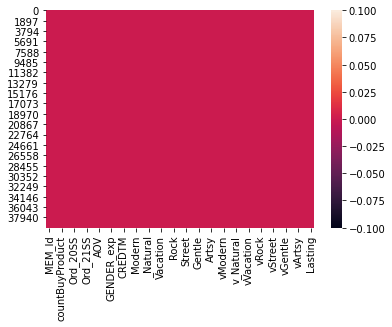

In [ ]:
#check if there's any lack of data
sns.heatmap(df.isnull())

In [ ]:
#Create a list of the pre-defined 13 preference
tastes = ['Elegant','Modern','Minimal',	'_Natural',	'Girly','Vacation'	,'Vintage',	'Rock',	'Outdoor',	'Street',	'Mode',	'Gentle',	'Preppie',	'Artsy']
for taste in tastes:
  df[taste] = df[taste] * 15 + df['v'+taste] #assign 15 times heavier weights to the purchace than pageview.

df['sum'] = df[tastes].sum(axis = 1)

In [ ]:
for taste in tastes:
  df[taste] = df[taste] / df['sum']

In [ ]:
profile = ['Otimes',	'countBuyProduct',	'countViewProduct',	'Ord_20SS',	'Ord_20AW',	'Ord_21SS',	'Ttl_Ord',	'AOV','Lasting','GENDER_adj']
columns =  ['MEM_Id'] + profile + tastes
print(columns)

['MEM_Id', 'Otimes', 'countBuyProduct', 'countViewProduct', 'Ord_20SS', 'Ord_20AW', 'Ord_21SS', 'Ttl_Ord', 'AOV', 'Lasting', 'GENDER_adj', 'Elegant', 'Modern', 'Minimal', '_Natural', 'Girly', 'Vacation', 'Vintage', 'Rock', 'Outdoor', 'Street', 'Mode', 'Gentle', 'Preppie', 'Artsy']


In [ ]:
df= df[(df['sum'] > 0) & (df['Otimes'] > 0)]
df = df.loc[:,columns]
df_t = df.loc[:,tastes] #df_fil.loc[:,columns]
df_t.tail()

,Elegant,Modern,Minimal,_Natural,Girly,Vacation,Vintage,Rock,Outdoor,Street,Mode,Gentle,Preppie,Artsy
10022,0.0,0.0,0.760000,0.080000,0.0,0.0,0.040000,0.0,0.000000,0.040000,0.0,0.04,0.04,0.0
10024,0.0,0.0,0.027778,0.027778,0.0,0.0,0.027778,0.0,0.444444,0.472222,0.0,0.00,0.00,0.0
10025,0.0,0.0,0.966667,0.033333,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.0
10027,0.0,0.0,0.484848,0.484848,0.0,0.0,0.000000,0.0,0.015152,0.015152,0.0,0.00,0.00,0.0
10029,0.0,0.0,0.057692,0.000000,0.0,0.0,0.000000,0.0,0.942308,0.000000,0.0,0.00,0.00,0.0


#K-means Clustering

In [ ]:
from sklearn.cluster import KMeans
clusters = 5
algorithm = KMeans(n_clusters=clusters, random_state=31)

In [ ]:
#fit the model
y_pred = algorithm.fit_predict(df_t)
print(y_pred[:20])

[1 0 0 0 0 0 4 3 0 0 0 0 0 0 0 0 4 0 0 0]


In [ ]:
#add the class to the data frame
df['class'] = y_pred
df_add = df.groupby('class').mean()
df_add = df_add.reindex(index = [2,1,3,4,0]) # 2 = Minimalist, 1 = StreetOutdoor, 3 = VintagePreppie, 4 = GirlyStreet, 0 = Rainbow.
df_add

,Otimes,countBuyProduct,countViewProduct,Ord_20SS,Ord_20AW,Ord_21SS,Ttl_Ord,AOV,Lasting,GENDER_adj,Elegant,Modern,Minimal,_Natural,Girly,Vacation,Vintage,Rock,Outdoor,Street,Mode,Gentle,Preppie,Artsy
class,,,,,,,,,,,,,,,,,,,,,,,,
2,1.222437,2.248549,13.418762,0.198259,0.221470,0.802708,2323.352998,1864.581238,159.620890,0.606383,0.030238,0.003370,0.834336,0.049362,0.006922,0.008977,0.011502,0.001260,0.010384,0.022084,0.003370,0.004085,0.011312,0.002798
1,1.173184,1.817505,6.318436,0.090317,0.554004,0.528864,2462.366853,1966.972067,170.719739,0.499069,0.007879,0.026863,0.029143,0.012430,0.004883,0.005423,0.018714,0.000898,0.422062,0.418632,0.026863,0.011347,0.012241,0.002623
3,1.320856,1.871123,14.804813,0.209091,0.673797,0.437968,3734.645989,2722.498930,215.883422,0.268449,0.017410,0.005185,0.046430,0.018437,0.008629,0.009599,0.299743,0.001813,0.017813,0.289652,0.005185,0.007201,0.270004,0.002900
4,1.543220,3.102542,27.872881,0.271186,0.844915,0.427119,4465.049153,2680.368644,237.327119,0.940678,0.062161,0.017385,0.056636,0.042136,0.308804,0.055182,0.029947,0.060989,0.024988,0.284669,0.017385,0.003024,0.024983,0.011711
0,1.645929,3.119266,43.453268,0.214736,0.766342,0.664851,5050.643922,2918.471904,209.178039,0.700115,0.161975,0.041576,0.274736,0.152018,0.043298,0.065047,0.046718,0.006557,0.031871,0.068332,0.041576,0.017683,0.035610,0.013003


In [ ]:
df_cluster = df_t.groupby(y_pred).mean() #calculate the average distribution of the style preference to see its general picture
df_cluster.index = df_cluster.index.map({0:'Rainbow',1:'StreetOutdoor',2:'Minimalist',3:'VintagePreppie',4:'GirlyStreet'}) # name each group mannually
df_cluster = df_cluster.reindex(index = ['Minimalist','StreetOutdoor','VintagePreppie','GirlyStreet','Rainbow']) #add index
df_cluster

,Elegant,Modern,Minimal,_Natural,Girly,Vacation,Vintage,Rock,Outdoor,Street,Mode,Gentle,Preppie,Artsy
Minimalist,0.030238,0.003370,0.834336,0.049362,0.006922,0.008977,0.011502,0.001260,0.010384,0.022084,0.003370,0.004085,0.011312,0.002798
StreetOutdoor,0.007879,0.026863,0.029143,0.012430,0.004883,0.005423,0.018714,0.000898,0.422062,0.418632,0.026863,0.011347,0.012241,0.002623
VintagePreppie,0.017410,0.005185,0.046430,0.018437,0.008629,0.009599,0.299743,0.001813,0.017813,0.289652,0.005185,0.007201,0.270004,0.002900
GirlyStreet,0.062161,0.017385,0.056636,0.042136,0.308804,0.055182,0.029947,0.060989,0.024988,0.284669,0.017385,0.003024,0.024983,0.011711
Rainbow,0.161975,0.041576,0.274736,0.152018,0.043298,0.065047,0.046718,0.006557,0.031871,0.068332,0.041576,0.017683,0.035610,0.013003


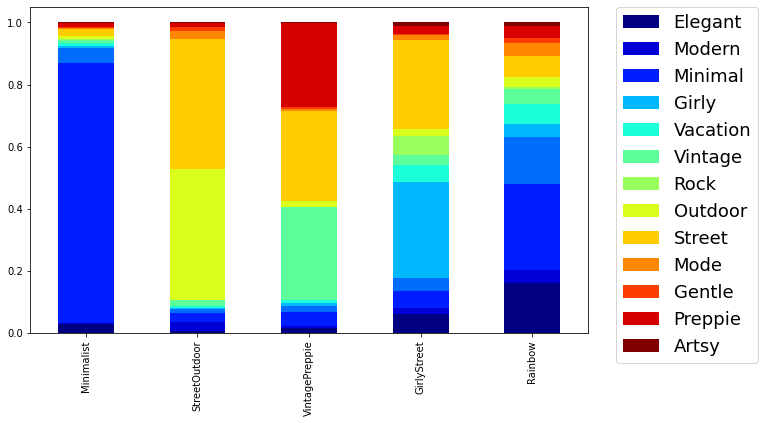

In [ ]:
#Show the average picture of the 5 groups
df_cluster.plot(kind = 'bar', stacked =True, figsize=(10,6),colormap='jet',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()

In [ ]:
#Rainbow is the group with the most diverse preferences, and Minimalist is the group with the least diverse preferences.
#We saw Rainbow outperform Minimalist significantly and gained the idea that we could educate Minimalist to grow into Rainbow by recommending appropriately diverse products.